# Coursework 1 - Synfire chains

The aim of this coursework is to reproduce and extend the results of the following paper:

[Diesmann et al (1999) "Stable propagation of synchronous spiking in cortical neural networks"](https://www.nature.com/articles/990101) ([pdf](http://www.honda-ri.de/pubs/pdf/1406.pdf))

You can extend the code developed in the exercises in weeks 1 and 2.

You will need to read the paper, paying particular attention to the Methods section, to understand what the model is. As is often the case in older scientific papers, no code is provided and not all the details needed are given. You will need to think and experiment a bit to fill in the gaps.

You should submit your results as a Jupyter notebook that can be run on Google Colab. You should describe your code and results. Your code should be clear, and well commented, and your text should be clearly written and easy to follow. Remember, it will be assessed by 3 or more randomly selected individuals from the class. They will download and run your code, and if it does not work or they cannot understand it, you will get fewer marks.

A more detailed, step-by-step guide follows.

## Task 1: implement a simulator for the model in the paper

Your simulator should have the following features:

1. Leaky integrate-and-fire neuron with alpha synapse acting on the current (note: not on the membrane potential). You should have two time constants, membrane time constant and alpha synapse time constant.
2. Background noise as a Poisson process (see notes below).
3. Refractoriness (see notes below).
4. Initialisation with an input spike burst as described in the paper.
5. All-to-all connectivity between layers. That is, each neuron in layer $i$ is connected to each neuron in layer $j$ (with the same weight).
6. Delay between layers (so a spike in layer $i$ takes a fixed amount of time before arriving in layer $i+1$).

You can build your simulator iteratively adding features as you verify the properties and reproduce the plots below. For task 2A, you only need feature (1). For task 2B you need features (1-3). For task 3 onwards you need all 6 features.

Recommended approach: try to solve task 2A first using only a simulator with feature (1). Now add features (2-3) and solve task 2B. Once you've finished that, go back and check your code still works for taks 2A. Continue like this.

### Poisson background noise

You can implement Poisson background noise by computing the mean number of expected noise spikes in any time step (product of sum of input firing rates and time step size), and then at each time step drawing a random, Poisson distributed value with this mean. You can the ``poisson`` function imported above to do this. Note that in this case there are two populations of neurons, one excitatory and one inhibitory.

### Refractoriness

After a spike, the neuron shuts down (membrane potential stays at reset value and incoming spikes are ignored) for a period of time called the refractory period. You can implement this by tracking, for each neuron, the last time it spiked, and only adding spikes for neurons which haven't fired within the refractory period.

### Suggested implementation

* A function that simulates a single layer of the network, taking the output spikes of the previous layer as an input argument, and returning its own output spikes.
* A function that generates spikes for an input burst in the same format as the input/output of the simulate layer function above.

In [58]:
# These imports should be enough to do everything in this coursework, but feel free to use others
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import poisson

In [59]:
# Global variables for normalising the spike response model
a = 0.0667  # Spike scaling factor - found experimentally
b = 4.669  # Spike offset factor - found experimentally
v_rest = -70  # Resting membrane potential in mV - from paper


# Main function to simulate layer with noise
def simulate_layer(
    num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=5
):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError(
            "You need to specify either spikes_in or num_neurons and num_time_steps"
        )

    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape

    # Parameters
    dt = 0.1  # Time step in ms - from paper
    v_rest = -70.0  # Resting membrane potential in mV - from paper
    v_threshold = -55.0  # Threshold potential in mV - from paper
    alpha_synapse = 0.40  # Alpha function decay time in ms - found experimentally
    membrane_time_constant = 10.0  # Membrane time constant - from paper
    abs_refractory = 2.0  # Absolute refractory period in ms - from paper
    W = 4.0  # Membrane resistance in GOhm - found experimentally
    a = 0.0667  # Spike scaling factor - found experimentally
    b = 4.669  # Spike offset factor - found experimentally
    exc_rate = 2.0  # Excitatory firing rate - from paper
    inh_rate = 12.5  # Inhibitory firing rate - from paper
    noise_synapses = 20000  # Total number of synapses from noise - from paper
    exc_synapses = int(
        noise_synapses * 0.88
    )  # Number of excitatory synapses - from paper stated that 88% of synapses are excitatory
    inh_synapses = int(
        noise_synapses * 0.12
    )  # Number of inhibitory synapses - from paper stated that 12% of synapses are inhibitory

    ### IMPLEMENTATION 6 - DELAY ###
    # If no spikes then fill array with zero values
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        # Apply input delay
        spikes_in = np.roll(spikes_in, int(delay / dt), axis=1)

    # Initialize variables for simulation
    v = np.full(num_neurons, fill_value=v_rest)
    x = np.zeros(num_neurons)
    y = np.zeros(num_neurons)
    t_last = np.full(num_neurons, abs_refractory - 1)

    # Record activity of neurons and spikes for output of the function (for plotting)
    v_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))

    ### IMPLEMENTATION 2 - NOISE ###
    if noise:
        # Initialise random voltage values
        v = np.random.uniform(low=v_rest, high=v_threshold, size=num_neurons)
        # Mean excitatory rate
        mean_exc_rate = exc_rate * (dt / 1000) * exc_synapses
        # Mean inhibitory rate
        mean_inh_rate = inh_rate * (dt / 1000) * inh_synapses
        for t_idx in range(num_time_steps):
            # Add noise to the input spikes using poisson distribution
            spikes_in[:, t_idx] += poisson(mean_exc_rate, num_neurons)
            spikes_in[:, t_idx] -= poisson(mean_inh_rate, num_neurons)

    # Run simulation
    for t_idx in range(num_time_steps):
        t = t_idx * dt

        ### IMPLEMENTATION 3 - REFRACTORINESS ###
        neurons_in_refractory = (
            t + abs_refractory
        ) < t_last  # Absolute refractory - check which neurons are in this period
        v[neurons_in_refractory] = (
            v_rest  # Neurons in refractory period are reset to rest
        )
        spikes_in[neurons_in_refractory, t_idx] = (
            0  # Set spikes to 0 for neurons in refractory period
        )

        ### IMPLEMENTATION 1 - SPIKE RESPONSE MODEL ###
        # Synaptic current updates
        dx_dt = (y - x) / alpha_synapse
        dy_dt = -y / alpha_synapse
        x += dx_dt * dt
        y += dy_dt * dt + spikes_in[:, t_idx]
        # Update membrane potential
        dv_dt = (W * x - (v - v_rest)) / membrane_time_constant
        v += dv_dt * dt

        # Check for spiking neurons
        spiking_neurons = (
            v >= v_threshold
        )  # Array of neurons that have spiked in timestep- 0 (not-spiked), 1 (spiked)
        spikes_out[spiking_neurons, t_idx] = 1
        v[spiking_neurons] = v_rest  # Spiking neurons are reset to rest
        t_last[spiking_neurons] = t  # Record time of last spike

        # Record membrane potential
        # b potential normalisation
        # a resting membrane potential
        v_rec[:, t_idx] = v

    return v_rec, spikes_out


### IMPLEMENTATION 4 - INPUT BURST ###
def input_burst(
    num_neurons=100, num_active=50, offset=0, sigma=0, num_time_steps=700, dt=0.1
):

    # Convert sigma from ms to timestep
    sigma = sigma / dt
    # Create array of spikes with dimensions of number of neurons and number of time steps - initially set to 0
    spikes = np.zeros((num_neurons, num_time_steps))
    # Generate random active neurons from the total number of neurons
    active_neurons = np.random.choice(num_neurons, num_active, replace=False)

    # Generate spikes for active neurons with normal distribution around offset with sigma as standard deviation and set to 1 if within time steps range else 0
    time_distribution = np.random.normal(offset, sigma, num_active)
    index = 0
    # For each time step, if the time distribution is within the range of time steps, set the spike to 1 else 0
    for t in time_distribution:
        if t >= 0 and t < num_time_steps:
            spikes[active_neurons[index], int(t)] = 1
        index += 1
    return spikes


### IMPLEMENTATION 5 - ALL TO ALL ###
def all_to_all(spikes, n_out=None):
    s = spikes.sum(axis=0)[None, :]
    if n_out is None:
        n_out = spikes.shape[0]
    return np.repeat(s, n_out, axis=0)

## Task 2: validate neuron, synapse and network properties

### Task 2A: validate postsynaptic potential

Write down the differential equations for your model.

Verify that you have implemented the neuron and synapse model correctly by feeding it a single input spike, plotting the membrane potential (postsynaptic potential, PSP) and checking that the time to peak, and peak value are as given in the paper. It doesn't have to be absolutely perfect, just close enough.

---
---

### The differential equations for our model:

The Alpha-synapse model is defined as follows:

$$
x(t) = H(t) e^{-\frac{t}{\tau_{x}}} \frac{t}{\tau_{x}} \tag{1}
$$

where $x(t)$ represents the Post-Synaptic Current, $\tau_{x}$ is the Alpha-synapse time constant, and $H(t)$ is the Heaviside function, which is zero for $t < 0$.

---

The post-synaptic potential $v(t)$ of a LIF neuron with synapses can be modeled by the following differential equation:

$$
\tau_{m} \frac{dv}{dt} = R x - v \tag{2}
$$

where:
- $v$ is the membrane potential,
- $\tau_{m}$ is the membrane time constant,
- $R$ is the membrane resistance, and
- $x$ is the input post-synaptic current.

---

From Equation (1), we derive the following differential equations:

$$
\tau_{x} \frac{dy}{dt} = -y \tag{3}
$$

$$
\tau_{x} \frac{dx}{dt} = y - x \tag{4}
$$

where $y$ is an intermediate variable representing part of the current dynamics, and $x$ is the actual post-synaptic current.

---

1. **Solution to Equation (3)**:

   The solution for $y(t)$ is given by:

   $$
   y(t) = y(0) e^{-\frac{t}{\tau_{x}}} \tag{5}
   $$

   This describes the exponential decay of $y$ over time, starting from $y(0)$.

2. **Solution to Equation (4)**:

   The solution for $x(t)$ can be expressed as:

   $$
   x(t) = x(0)e^{-\frac{t}{\tau_{x}}} + \left(1 - e^{-\frac{t}{\tau_{x}}}\right) y(t) \tag{6}
   $$

   This shows how $x$ evolves as a function of its initial value $x(0)$ and the influence of $y(t)$, where $\tau_x$ governs the decay and buildup dynamics.

3. **Solution for Equation (2)**:

   The solution for the post-synaptic potential $v(t)$ is given by:

   $$
   v(t) = v(0) e^{-\frac{t}{\tau_{m}}} + \left(1 - e^{-\frac{t}{\tau_{m}}}\right) R x(t) \tag{7}
   $$

   This equation combines the initial membrane potential $v(0)$ with the effect of synaptic input over time.

---

Equations (5), (6), and (7) provide a framework for implementing the LIF neuron model with an Alpha-synapse. Together, these equations describe the dynamics of synaptic input and the neuron's response.


Alpha PSP verification
  Maximum of PSP is 0.0092V and should be 0.0093V
  Maximum is attained at time 1.70 and should be 1.70



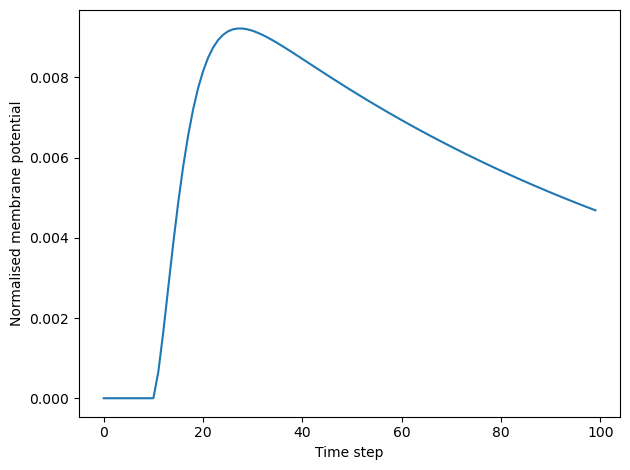

In [60]:
# Verify synapse properties with no background noise and single input spike
s_in = np.zeros((1, 100))  # duration 10ms
s_in[0, 10] = 1  # single input spike at time t=1ms
v, s = simulate_layer(
    spikes_in=s_in, noise=False, delay=0
)  # Simulate layer with no noise and no delay
# Normalise membrane potential with a and b values
v = a * v + b
# Plot membrane potential
plt.figure()
plt.plot(v[0, :])
plt.xlabel("Time step")
plt.ylabel("Normalised membrane potential")
plt.tight_layout()
print("Alpha PSP verification")
print(f"  Maximum of PSP is {v.max():.4f}V and should be 0.0093V")
print(f"  Maximum is attained at time {(v.argmax()-10)*0.1:.2f} and should be 1.70")
print()

Expected results:

![Expected results](result_2a.png)

### Task 2B: validate background noise

Verify that in the absence of any input spikes, neurons in the network fire noise spikes at approximately the rate given in the paper, and that the mean and standard deviation of the membrane potential is as given in the paper. Plot the output spikes and 5 membrane potentials to check that the results seem sensible.

Background firing rate verification
  Mean rate is 2.4 Hz, should be 2Hz
  Membrane potential mean is 0.007909V, should be 0.00825V
  Membrane potential std is 0.002848V, should be 0.00285V


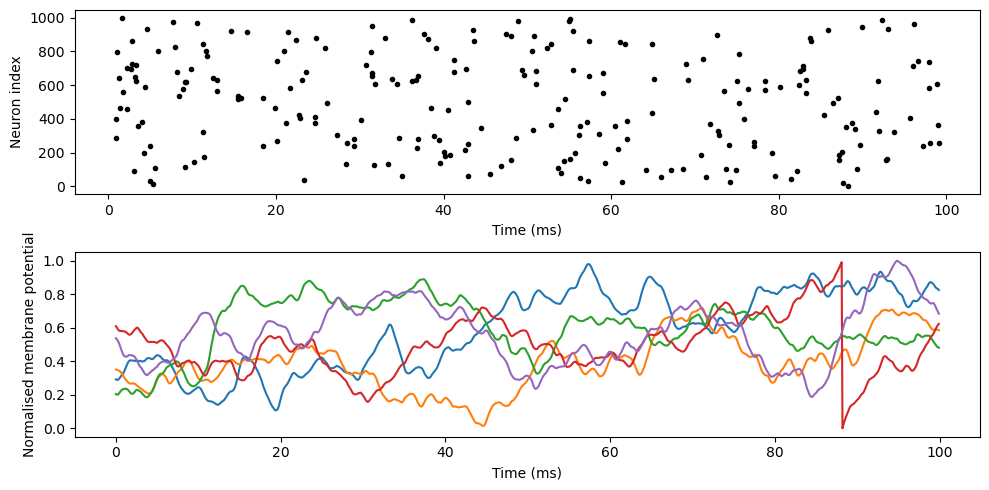

In [61]:
# Verify background noise gives appropriate level of output noise
v_original, s = simulate_layer(num_neurons=1000, num_time_steps=1000)
# Normalise membrane potential with a and b values for plotting
v = a * v_original + b
i, t = s.nonzero()
t = t * 0.1  # dt
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t, i, ".k")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.subplot(212)
plt.plot(np.arange(1000) * 0.1, v[:5, :1000].T)
plt.xlabel("Time (ms)")
plt.ylabel("Normalised membrane potential")
plt.tight_layout()
# Normalise v for verification of background firing rate and membrane potential
v_normalised = (v_original - v_rest) / 1000
print("Background firing rate verification")
print(f"  Mean rate is {s.sum()/(1000*1000*0.1*1e-3):.1f} Hz, should be 2Hz")
print(f"  Membrane potential mean is {(v_normalised.mean()):6f}V, should be 0.00825V")
print(f"  Membrane potential std is {v_normalised.std():6f}V, should be 0.00285V")

Expected results:

![Expected results](results_2b.png)

## Task 3: reproduce figures 1d and 1e from the paper

The plotting doesn't have to be perfect, but it should be recognisably similar to the paper.

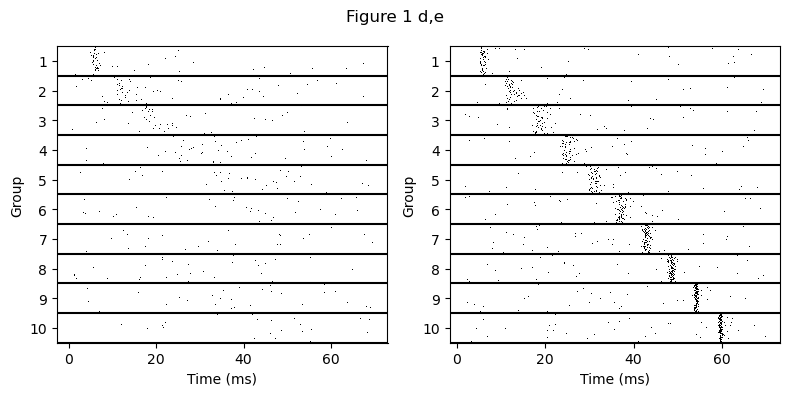

In [62]:
# Verify figure 1d,e
num_neurons = 100  # Number of neurons (from paper)
plt.figure(figsize=(8, 4))
a_values = [50, 48]  # Number of active neurons (from paper)

for plotidx, a in enumerate(a_values):
    s = input_burst(num_neurons=num_neurons, num_active=a)
    plt.subplot(1, 2, plotidx + 1)
    for layer in range(10):
        s_accumulated = all_to_all(s, num_neurons)
        _, s = simulate_layer(spikes_in=s_accumulated)
        i, t = s.nonzero()
        plt.plot(t * 0.1, i / 100 + 9 - layer, ",k")
        plt.axhline(layer, c="k")
    plt.ylim(0, 10)
    plt.yticks(np.arange(10) + 0.5, np.arange(1, 11)[::-1])
    plt.xlabel("Time (ms)")
    plt.ylabel("Group")
plt.suptitle("Figure 1 d,e")
plt.tight_layout()

Expected results (may not be exactly the same each time you run):

![Expected results](result_3.png)

## Task 4: reproduce figures 2c and 2d

In this case, the paper is lacking a lot of detail in how to estimate the probability and spread of an output spike. You are unlikely to be able to perfectly reproduce the output, but you should be able to get something similar and justify your results, or explain why you think the paper got it wrong if you disagree.

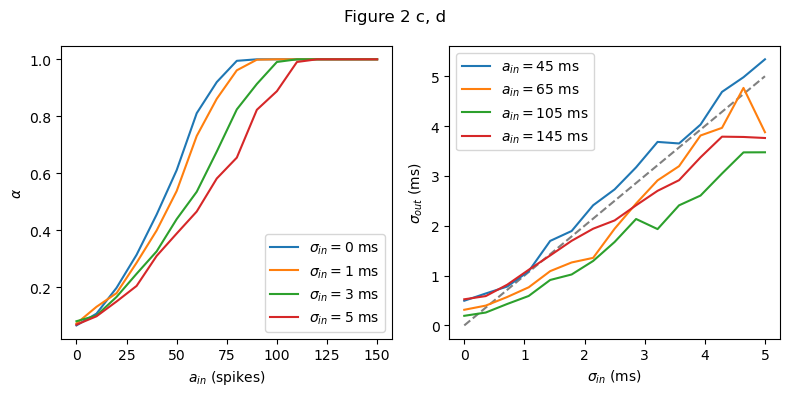

In [63]:
# Verify figure 2c,d
def estimate_pulse_parameters(s, num_neurons):  # Updated function signature
    # Now we want to estimate the number of spikes caused and their spread.
    # alpha = probability of an output spike = number of output spikes / number of neurons
    # sigma_out = spread (in ms) of output spikes caused by the pulse
    # sum_spikes = number of spikes caused by the pulse
    sum_spikes = np.sum(s)
    # sum_spikes = np.sum(np.any(s >= 1, axis=1))
    # Make sure the sum doesn't exceed the number of neurons
    sum_spikes = min(sum_spikes, num_neurons)

    # Avoid division by zero if no neurons are present
    alpha = sum_spikes / num_neurons if num_neurons > 0 else 0

    # Find all instances where there was a spike
    _, spike_times = s.nonzero()

    # Initialize sigma_out to 0 as default if there are no spikes or no filtered spikes
    sigma_out = 0

    # Check if there are any spike times
    if spike_times.size > 0:
        # Compute IQR bounds for filtering outliers in spike times using 1.5*IQR rule for outliers detection
        Q1, Q3 = np.percentile(spike_times, [25, 75])
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        # Filter spike times based on IQR bounds to remove outliers
        filtered_spikes = spike_times[
            (spike_times >= lower_bound) & (spike_times <= upper_bound)
        ]

        # If filtered spikes are found, calculate standard deviation of filtered spikes and multiply by 0.1 to get sigma_out value in time steps, where dt = 0.1
        if filtered_spikes.size > 0:
            sigma_out = np.std(filtered_spikes) * 0.1

    return alpha, sigma_out


def neural_transmission(a_in, sigma_in, repeats=5, dt=0.1):
    alpha_sum = 0
    sigma_out_sum = 0
    offset = 150
    num_time_steps = 300
    num_neurons = 150

    # Repeat the process and average results to smooth out noise
    for _ in range(repeats):
        # Generate an input burst of a_in spikes with spread sigma_in
        s = input_burst(
            num_neurons=num_neurons,
            num_active=a_in,
            offset=offset,
            sigma=sigma_in,
            dt=dt,
            num_time_steps=num_time_steps,
        )

        # Connect the input burst to all neurons in the next layer
        s = all_to_all(s)

        # Run the simulation for one layer with added noise
        _, s = simulate_layer(spikes_in=s, noise=True, delay=0)

        # Estimate alpha and sigma_out and accumulate for averaging
        alpha_temp, sigma_out_temp = estimate_pulse_parameters(s, num_neurons)
        alpha_sum += alpha_temp
        sigma_out_sum += sigma_out_temp

    # Average results across repeats
    alpha = alpha_sum / repeats
    sigma_out = sigma_out_sum / repeats
    return alpha, sigma_out


# Plotting figure 2c,d
plt.figure(figsize=(8, 4))
plt.subplot(121)
for sigma in [0, 1, 3, 5]:
    A_IN = np.arange(0, 150 + 1, 10)
    ALPHA = [neural_transmission(a_in, sigma)[0] for a_in in A_IN]
    plt.plot(A_IN, ALPHA, label=f"$\\sigma_{{in}}={sigma}$ ms")
plt.xlabel(r"$a_{in}$ (spikes)")
plt.ylabel(r"$\alpha$")
plt.legend(loc="best")

plt.subplot(122)
for a_in in [45, 65, 105, 145]:
    SIGMA_IN = np.linspace(0, 5, 15)
    SIGMA_OUT = [neural_transmission(a_in, sigma_in)[1] for sigma_in in SIGMA_IN]
    plt.plot(SIGMA_IN, SIGMA_OUT, label=f"$a_{{in}}={a_in}$ ms")
plt.plot([0, 5], [0, 5], ls="--", c="grey", zorder=-1)
plt.xlabel(r"$\sigma_{in}$ (ms)")
plt.ylabel(r"$\sigma_{out}$ (ms)")
plt.legend(loc="best")
plt.suptitle("Figure 2 c, d")
plt.tight_layout()

Expected results (as you can see, not exactly the same as in the paper which I couldn't reproduce perfectly):

![Expected results](result_4.png)

## Task 5: reproduce figure 3c

It is sufficient to plot some of the trajectories, and not the separatrix (dashed line).

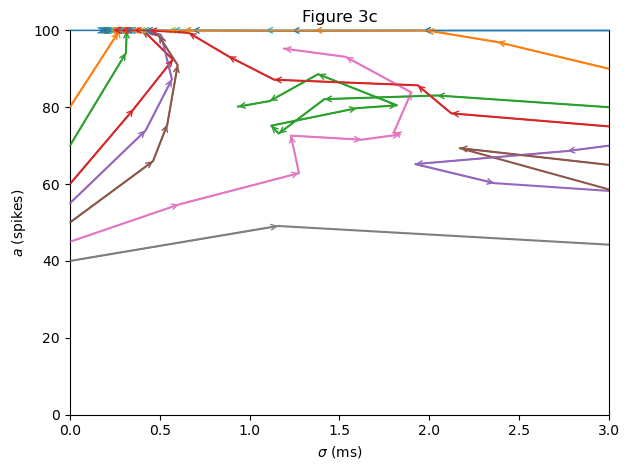

In [64]:
# TODO: Replace the ... below
# Validation figure 3c
# Starting points based on state-space dynamics from the paper
starting_points = [
    (100, 0),
    (80, 0),
    (70, 0),
    (60, 0),
    (55, 0),
    (50, 0),
    (45, 0),
    (40, 0),
    (100, 1),
    (100, 2),
    (100, 3),
    (90, 3),
    (80, 3),
    (75, 3),
    (70, 3),
    (65, 3),
]
repeats = 20  # Number of repeats for averaging to get smooth results
dt = 0.1  # Time step in ms
offset = 150  # Offset of 15ms - so that most of the spikes are within the time frame
num_neurons = 100  # From paper

for idx, (a, sigma) in enumerate(starting_points):
    A, SIGMA = [a], [sigma]
    # Generate input burst as spike volley
    s = input_burst(
        num_neurons=num_neurons,
        num_active=a,
        offset=offset,
        sigma=sigma,
        dt=dt,
        num_time_steps=400,
    )

    # Propagation and Update of `a` and `sigma` over 10 iterations
    for _ in range(10):
        A.append(a)
        SIGMA.append(sigma)

        a_total, sigma_total = 0, 0

        # Repeat for averaging over multiple realizations
        for _ in range(repeats):
            spikes = all_to_all(s)
            _, spikes = simulate_layer(
                num_neurons=num_neurons,
                spikes_in=spikes,
                noise=True,
                num_time_steps=400,
                delay=0,
            )
            alpha_temp, sigma_temp = estimate_pulse_parameters(spikes, num_neurons)

            # Accumulate values
            a_temp = int(alpha_temp * num_neurons)
            a_total += a_temp
            sigma_total += sigma_temp

        s = spikes

        # Update `a` and `sigma` based on averages
        a = a_total / repeats
        sigma = sigma_total / repeats

        # Implement attractor and saddle adjustments
        # Nudge values towards the attractor or saddle region based on their current location
        """' HANA are we allowed to nudge like this?
        if a > 95 and sigma < 0.5:
            a = max(95, a - 2)  # Give flexibility to stabilize near attractor
            sigma = 0.5
        elif a < 65 and sigma > 1.2:
            a = max(0, a - 1)  # Move towards extinction if near saddle
            sigma = min(3, sigma + 0.15)
        """
        # Update spikes for the next iteration
        s = spikes
        a = a_total / repeats
        sigma = sigma_total / repeats
    plt.figure
    plt.plot(SIGMA, A, c=f"C{idx}")
    for i in range(len(SIGMA) - 1):
        plt.annotate(
            "",
            (SIGMA[i + 1], A[i + 1]),
            xytext=(SIGMA[i], A[i]),
            arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=f"C{idx}"),
        )
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.xlabel(r"$\sigma$ (ms)")
plt.ylabel("$a$ (spikes)")
plt.title("Figure 3c")
plt.tight_layout()

Expected results:

![Expected results](result_5.png)

## Task 6 (optional extra credit)

It is possible to obtain a first class grade from the parts above. This part is for extra credit.

Investigate some aspect of the model that you think is interesting and is not covered in the paper. Explain why you think it's interesting and present your results coherently.

Some ideas (but feel free to use your own):
* Do the results depend on the choice of model parameters given in the paper? How precisely?
* Do the results depend on the choice of synapse model in the paper?
* Do the results depend on all-to-all connectivity between layers?